# Part 1: ASL Classification
Convolutional neural network (CNN) for classification of ASL signs. 
Team: Yuliia Nikolaenko, Mihaela Grigore, Lara Wagner.

In [ ]:
# Import Tensorflow 2.0
#%tensorflow_version 2.x --> only google collab
import tensorflow as tf 

!pip install mitdeeplearning
import mitdeeplearning as mdl

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

import cv2
import os

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import time
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix


from keras import layers
from keras.models import Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K

from sklearn.metrics import classification_report, confusion_matrix


You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


## 1.1 ASL Dataset

We will load the dataset and display a sample for each sign of the training dataset from it:

In [ ]:
train_dir = "data/asl_alphabet_train/asl_alphabet_train/"
test_dir =  "data/asl_alphabet_test/asl_alphabet_test/"
#IMG_SIZE = 64
IMG_SIZE = 28
labels_map = {'A':0,'B':1,'C': 2, 'D': 3, 'E':4,'F':5,'G':6, 'H': 7, 'I':8, 'J':9,'K':10,'L':11, 'M': 12, 'N': 13, 'O':14, 
                'P':15,'Q':16, 'R': 17, 'S': 18, 'T':19, 'U':20,'V':21, 'W': 22, 'X': 23, 'Y':24, 'Z':25, 
                'del': 26, 'nothing': 27,'space':28}

ROWS = IMG_SIZE
COLS = IMG_SIZE
CHANNELS = 3
CLASSES = 29

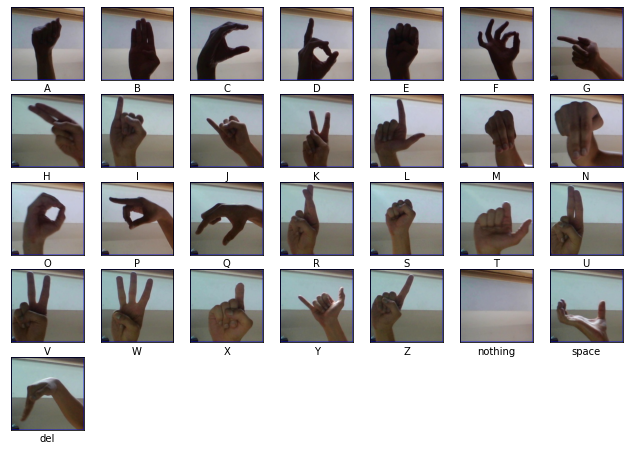

In [ ]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']
plt.figure(figsize=(11, 11))
for i in range (0,29):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = train_dir + "/{0}/{0}1.jpg".format(classes[i])
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(classes[i])

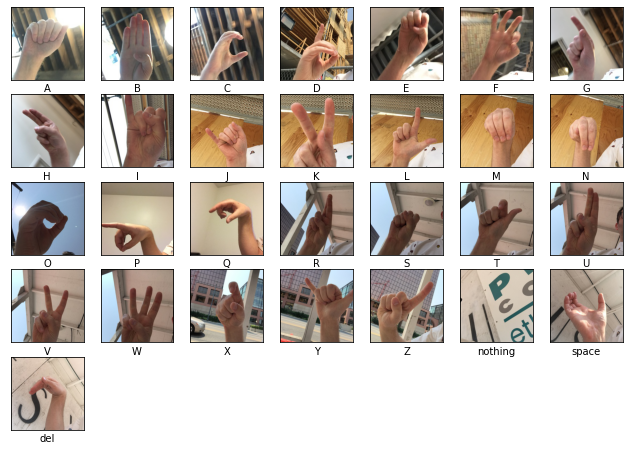

In [ ]:
plt.figure(figsize=(11, 11))
for i in range (0,29):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = test_dir + "/{0}/{0}0001_test.jpg".format(classes[i])
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(classes[i])

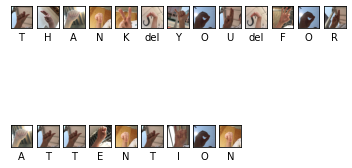

In [ ]:
thankyou = [19,7,0,13,10,28, 24,14,20,28, 5,14,17,0,19,19,4,13,19,8,14,13]
for i in range(len(thankyou)):
    path = test_dir + "/{0}/{0}0001_test.jpg".format(classes[thankyou[i]])
    img = plt.imread(path)
    plt.subplot(2,13,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.xlabel(classes[thankyou[i]])


In [ ]:
#dict_characters=labels_map
#df = pd.DataFrame()
#df["labels"]=y_train
#lab = df['labels']
#dist = lab.value_counts()
#plt.figure(figsize=(12,8))
#sns.countplot(lab)
#print(dict_characters)

In [ ]:
'''
We don't have enough memory to work with all our data
So we read the first m elements from each of the 29 classes as train data
And the next m elements as test data
Final data size:
    m * 29 train examples
    m * 29 test examples
'''
#m = 100
m = 900

def create_train_data():
    x_train = []
    y_train = []
    for folder_name in os.listdir(train_dir):
        label = labels_map[folder_name]
        for image_filename in tqdm(os.listdir(train_dir + folder_name)[:m]):
            path = os.path.join(train_dir,folder_name,image_filename)
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR),(IMG_SIZE, IMG_SIZE ))
            x_train.append(np.array(img))
            y_train.append(label)
    print("Done creating train data")
    return x_train, y_train

def create_test_data():
    x_test = []
    y_test = []
    for folder_name in os.listdir(train_dir):
        label = labels_map[folder_name]
        for image_filename in tqdm(os.listdir(train_dir + folder_name)[m:(2*m)]):
            path = os.path.join(train_dir,folder_name,image_filename)
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR),(IMG_SIZE, IMG_SIZE ))
            x_test.append(np.array(img))
            y_test.append(label)
    print("Done creating train data")
    return x_test, y_test



In [ ]:
'''def create_test_data():
    x_test = []
    y_test = []
    for folder_name in os.listdir(test_dir):
        label = labels_map[folder_name]
        for image_filename in tqdm(os.listdir(test_dir + folder_name)[:10]):
            path = os.path.join(test_dir,folder_name,image_filename)
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR),(IMG_SIZE, IMG_SIZE ))
            x_test.append(np.array(img))
            y_test.append(label)
    print("Done creating test data")
    return x_test,y_test
'''

'def create_test_data():\n    x_test = []\n    y_test = []\n    for folder_name in os.listdir(test_dir):\n        label = labels_map[folder_name]\n        for image_filename in tqdm(os.listdir(test_dir + folder_name)[:10]):\n            path = os.path.join(test_dir,folder_name,image_filename)\n            img = cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR),(IMG_SIZE, IMG_SIZE ))\n            x_test.append(np.array(img))\n            y_test.append(label)\n    print("Done creating test data")\n    return x_test,y_test\n'

In [ ]:
x_train_set, y_train_set= create_train_data()  

100%|██████████| 900/900 [00:01<00:00, 836.91it/s]Done creating train data



In [ ]:
x_test_set,y_test_set = create_test_data()

100%|██████████| 900/900 [00:02<00:00, 415.13it/s]Done creating train data



Transform our lists to arrays

In [ ]:
y_train_arr = np.array(y_train_set)
y_train_arr = y_train_arr.reshape(1, len(y_train_arr))

y_test_arr = np.array(y_test_set)
y_test_arr = y_test_arr.reshape(1, len(y_test_arr))

print('Before encoding: ')
print('y_train_arr shape', np.shape(y_train_arr))
print('y_train_arr type', type(y_train_arr))

X_train = np.array(x_train_set)/255
X_test = np.array(x_test_set)/255

Before encoding: 
y_train_arr shape (1, 26100)
y_train_arr type <class 'numpy.ndarray'>


In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [ ]:
Y_train = convert_to_one_hot(y_train_arr, CLASSES).T
Y_test = convert_to_one_hot(y_test_arr, CLASSES).T

In [ ]:
print ("number of training examples =", X_train.shape[0])
print ("number of test examples =", X_test.shape[0])
print ("X_train shape:", X_train.shape)
print ("Y_train shape:", Y_train.shape)
print ("X_test shape:", X_test.shape)
print ("Y_test shape:", Y_test.shape)

number of training examples = 26100
number of test examples = 26100
X_train shape: (26100, 28, 28, 3)
Y_train shape: (26100, 29)
X_test shape: (26100, 28, 28, 3)
Y_test shape: (26100, 29)


# CNN

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Flatten())

model_cnn.add(Dense(128, activation='relu'))

model_cnn.add(Dense(29, activation='softmax'))

model_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
activation_3 (Activation)    (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 64)       

In [ ]:
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_cnn.fit(X_train, Y_train,
          epochs=50,
          batch_size=64,
          verbose=2,
          validation_data=(X_test, Y_test))

Epoch 1/50
46/46 - 22s - loss: 3.3500 - accuracy: 0.0476 - val_loss: 3.2844 - val_accuracy: 0.0521
Epoch 2/50
46/46 - 22s - loss: 3.0586 - accuracy: 0.1421 - val_loss: 2.7609 - val_accuracy: 0.2272
Epoch 3/50
46/46 - 22s - loss: 2.4090 - accuracy: 0.3145 - val_loss: 2.1820 - val_accuracy: 0.3517
Epoch 4/50
46/46 - 22s - loss: 1.7690 - accuracy: 0.4724 - val_loss: 1.7709 - val_accuracy: 0.4759
Epoch 5/50
46/46 - 22s - loss: 1.3293 - accuracy: 0.5869 - val_loss: 1.4739 - val_accuracy: 0.5528
Epoch 6/50
46/46 - 22s - loss: 0.9734 - accuracy: 0.6990 - val_loss: 1.3329 - val_accuracy: 0.6269
Epoch 7/50
46/46 - 22s - loss: 0.7364 - accuracy: 0.7728 - val_loss: 1.2004 - val_accuracy: 0.6721
Epoch 8/50
46/46 - 22s - loss: 0.5433 - accuracy: 0.8362 - val_loss: 1.1867 - val_accuracy: 0.6810
Epoch 9/50
46/46 - 22s - loss: 0.4263 - accuracy: 0.8731 - val_loss: 1.1442 - val_accuracy: 0.7166
Epoch 10/50
46/46 - 22s - loss: 0.3148 - accuracy: 0.9110 - val_loss: 1.2664 - val_accuracy: 0.7048
Epoch 11/

46/46 - 22s - loss: 3.5477e-04 - accuracy: 1.0000 - val_loss: 1.4567 - val_accuracy: 0.8166
Epoch 45/50
46/46 - 22s - loss: 3.3420e-04 - accuracy: 1.0000 - val_loss: 1.4635 - val_accuracy: 0.8166
Epoch 46/50
46/46 - 22s - loss: 3.1507e-04 - accuracy: 1.0000 - val_loss: 1.4742 - val_accuracy: 0.8169
Epoch 47/50
46/46 - 22s - loss: 2.9690e-04 - accuracy: 1.0000 - val_loss: 1.4812 - val_accuracy: 0.8162
Epoch 48/50
46/46 - 22s - loss: 2.8181e-04 - accuracy: 1.0000 - val_loss: 1.4888 - val_accuracy: 0.8159
Epoch 49/50
46/46 - 22s - loss: 2.6956e-04 - accuracy: 1.0000 - val_loss: 1.4960 - val_accuracy: 0.8162
Epoch 50/50
46/46 - 22s - loss: 2.6236e-04 - accuracy: 1.0000 - val_loss: 1.5019 - val_accuracy: 0.8183


In [ ]:
model_cnn_metrics = pd.DataFrame(model_cnn.history.history)

In [ ]:
model_cnn_metrics

,loss,accuracy,val_loss,val_accuracy
0,3.349956,0.047586,3.284438,0.052069
1,3.058625,0.142069,2.760904,0.227241
2,2.409022,0.314483,2.182019,0.351724
3,1.768962,0.472414,1.770918,0.475862
4,1.329290,0.586897,1.473931,0.552759
5,0.973424,0.698965,1.332890,0.626897
6,0.736408,0.772759,1.200399,0.672069
7,0.543339,0.836207,1.186703,0.681035
8,0.426279,0.873103,1.144233,0.716552
9,0.314848,0.911034,1.266366,0.704828


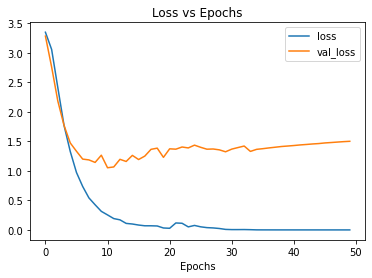

In [ ]:
model_cnn_metrics[['loss','val_loss']].plot()
plt.xlabel('Epochs')
plt.title('Loss vs Epochs')
plt.show()

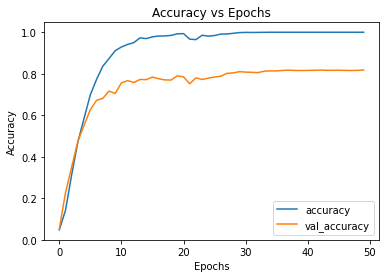

In [ ]:
model_cnn_metrics[['accuracy','val_accuracy']].plot()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

In [ ]:
model_cnn_predictions = model_cnn.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
Y_test_form = []

for array in Y_test:
    Y_test_form.append(np.argmax(array))

In [ ]:
print(classification_report(Y_test_form,model_cnn_predictions))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75       100
           1       0.88      0.86      0.87       100
           2       0.98      0.95      0.96       100
           3       0.91      0.84      0.87       100
           4       0.65      0.73      0.69       100
           5       0.97      0.83      0.89       100
           6       0.80      0.84      0.82       100
           7       0.89      0.88      0.88       100
           8       0.83      0.93      0.88       100
           9       0.82      0.91      0.86       100
          10       0.76      0.86      0.81       100
          11       0.88      0.92      0.90       100
          12       0.74      0.74      0.74       100
          13       0.90      0.79      0.84       100
          14       0.77      0.81      0.79       100
          15       0.90      0.87      0.88       100
          16       0.89      0.93      0.91       100
          17       0.74    

# ResNet

### 1. Identity Block
We'll implement an identity block, in which the skip connection "skips over" 3 hidden layers.       

**Arguments:**  
- X - input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)         
- f - integer, specifying the shape of the middle CONV's window for the main path
- filters - python list of integers, defining the number of filters in the CONV layers of the main path
- stage - integer, used to name the layers, depending on their position in the network
- block - string/character, used to name the layers, depending on their position in the network

**Returns:**
X - output of the identity block, tensor of shape (n_H, n_W, n_C)

In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

Sanity check if the identity function works

In [ ]:
# tf.compat.v1 instead of tf as functions are outdated
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
    A_prev = tf.compat.v1.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.compat.v1.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = ", out[0][1][1][0])

out =  [1.884208   0.         0.33887187 1.4663244  0.         0.5185081 ]


### 2. Convolutional Block

**Arguments:**
- X - input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
- f - integer, specifying the shape of the middle CONV's window for the main path
- filters - python list of integers, defining the number of filters in the CONV layers of the main path
- stage - integer, used to name the layers, depending on their position in the network
- block - string/character, used to name the layers, depending on their position in the network
- s - Integer, specifying the stride to be used

**Returns:**
X - output of the convolutional block, tensor of shape (n_H, n_W, n_C)

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

Again testing if convolutional block works

In [ ]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
    A_prev = tf.compat.v1.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.compat.v1.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = ",out[0][1][1][0])

out =  [0.6986004 0.        0.        0.        0.        0.       ]


### 3 Building our first ResNet model (50 layers)

**Arguments:**
- input_shape - shape of the images of the dataset
- classes - integer, number of classes

**Returns:**
model - a Model() instance in Keras

In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 29):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
# build the model's graph
model = ResNet50(input_shape =(ROWS, COLS, CHANNELS), classes = CLASSES)

In [ ]:
#Now we need to configure the learning process by compiling the model.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#The model is now ready to be trained. Run the following cell to train your model on 100 epochs with a batch size of 64:
model.fit(X_train, Y_train, epochs = 100, batch_size = 100, shuffle = True, verbose = 1)

Epoch 1/100
29/29 [==============================] - 368s 13s/step - loss: 4.6781 - accuracy: 0.0786
Epoch 2/100
29/29 [==============================] - 351s 12s/step - loss: 3.4596 - accuracy: 0.1662
Epoch 3/100
29/29 [==============================] - 352s 12s/step - loss: 2.6906 - accuracy: 0.2614
Epoch 4/100
29/29 [==============================] - 352s 12s/step - loss: 2.2750 - accuracy: 0.3824
Epoch 5/100
29/29 [==============================] - 352s 12s/step - loss: 2.2139 - accuracy: 0.4752
Epoch 6/100
29/29 [==============================] - 352s 12s/step - loss: 1.9147 - accuracy: 0.4345
Epoch 7/100
29/29 [==============================] - 352s 12s/step - loss: 1.5153 - accuracy: 0.5466
Epoch 8/100
29/29 [==============================] - 351s 12s/step - loss: 1.0196 - accuracy: 0.6738
Epoch 9/100
29/29 [==============================] - 352s 12s/step - loss: 0.6040 - accuracy: 0.7852
Epoch 10/100
29/29 [==============================] - 351s 12s/step - loss: 0.4301 - accura

29/29 [==============================] - 351s 12s/step - loss: 0.3716 - accuracy: 0.8907
Epoch 12/100
29/29 [==============================] - 351s 12s/step - loss: 0.4320 - accuracy: 0.8628
Epoch 13/100
29/29 [==============================] - 351s 12s/step - loss: 0.3396 - accuracy: 0.8934
Epoch 14/100
29/29 [==============================] - 349s 12s/step - loss: 0.2242 - accuracy: 0.9224
Epoch 15/100
29/29 [==============================] - 351s 12s/step - loss: 0.1305 - accuracy: 0.9593
Epoch 16/100
29/29 [==============================] - 351s 12s/step - loss: 0.0943 - accuracy: 0.9710
Epoch 17/100
29/29 [==============================] - 351s 12s/step - loss: 0.0897 - accuracy: 0.9769
Epoch 18/100
29/29 [==============================] - 350s 12s/step - loss: 0.0778 - accuracy: 0.9786
Epoch 19/100
29/29 [==============================] - 350s 12s/step - loss: 0.1787 - accuracy: 0.9490
Epoch 20/100
29/29 [==============================] - 351s 12s/step - loss: 0.1114 - accuracy: 

Let's save our trained model to file

In [ ]:
'''# serialize model to JSON
model_json = model.to_json()
with open("resnet_first10.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("resnet_first10.h5")
print("Saved model to file")'''

'# serialize model to JSON\nmodel_json = model.to_json()\nwith open("resnet_first10.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("resnet_first10.h5")\nprint("Saved model to file")'

In [ ]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

91/91 [==============================] - 28s 309ms/step - loss: 0.3290 - accuracy: 0.9303
Loss = 0.328961580991745
Test Accuracy = 0.930344820022583


In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

### Visualization of the model

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

NameError: name 'model' is not defined

We will visualize a random image

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def display_image(num):
    label = y_train[num]
    plt.title('Label: %d' % (label))
    image = x_train[num].reshape([IMG_SIZE,IMG_SIZE])
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
display_image(1000)

## 1.2 Neural Network for ASL Classification

We'll first build a simple neural network consisting of two fully connected layers and apply this to the digit classification task. Our network will ultimately output a probability distribution over the 29 classes (0-28).

In [ ]:
def build_fc_model():
  fc_model = tf.keras.Sequential([
      # First define a Flatten layer
      tf.keras.layers.Flatten(),

      # '''TODO: Define the activation function for the first fully connected (Dense) layer.'''
      tf.keras.layers.Dense(128, activation= 'relu'),

      # '''TODO: Define the second Dense layer to output the classification probabilities'''
      tf.keras.layers.Dense(29, activation= 'softmax')
      
  ])
  return fc_model

model_sgd = build_fc_model()

In [ ]:
'''TODO: Experiment with different optimizers and learning rates. How do these affect
    the accuracy of the trained model? Which optimizers and/or learning rates yield
    the best performance?'''
    #sparse_categorical_crossentropy => not good for the one hot encoded y label
model_sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 64
EPOCHS = 100

In [ ]:
X_train.shape

(26100, 28, 28, 3)

In [ ]:
model_sgd_history = model_sgd.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, Y_train)) 


Epoch 1/100
408/408 [==============================] - 3s 6ms/step - loss: 0.4660 - accuracy: 0.8775 - val_loss: 0.5537 - val_accuracy: 0.8394
Epoch 2/100
408/408 [==============================] - 2s 5ms/step - loss: 0.4642 - accuracy: 0.8769 - val_loss: 0.5541 - val_accuracy: 0.8299
Epoch 3/100
408/408 [==============================] - 2s 5ms/step - loss: 0.4615 - accuracy: 0.8794 - val_loss: 0.5114 - val_accuracy: 0.8523
Epoch 4/100
408/408 [==============================] - 2s 5ms/step - loss: 0.4589 - accuracy: 0.8772 - val_loss: 0.5306 - val_accuracy: 0.8400
Epoch 5/100
408/408 [==============================] - 2s 5ms/step - loss: 0.4498 - accuracy: 0.8810 - val_loss: 0.5435 - val_accuracy: 0.8362
Epoch 6/100
408/408 [==============================] - 2s 5ms/step - loss: 0.4484 - accuracy: 0.8821 - val_loss: 0.5402 - val_accuracy: 0.8365
Epoch 7/100
408/408 [==============================] - 2s 5ms/step - loss: 0.4414 - accuracy: 0.8851 - val_loss: 0.4891 - val_accuracy: 0.8629

In [ ]:
print(model_sgd.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 2352)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               301184    
_________________________________________________________________
dense_21 (Dense)             (None, 29)                3741      
Total params: 304,925
Trainable params: 304,925
Non-trainable params: 0
_________________________________________________________________
None


### Evaluate accuracy on the test dataset

In [ ]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = model_sgd.evaluate(x= X_test, y=Y_test)
'''TODO: Use the evaluate method to test the model!'''
train_loss, train_acc = model_sgd.evaluate(x= X_train, y=Y_train)
print('Test accuracy:', test_acc)
print('Train accuracy:', train_acc)

816/816 [==============================] - 1s 2ms/step - loss: 0.1897 - accuracy: 0.9648
Test accuracy: 0.9318773746490479
Train accuracy: 0.9647509455680847


In [ ]:
model_fnn_metrics = pd.DataFrame(model_sgd_history.history)

In [ ]:
model_fnn_metrics

,loss,accuracy,val_loss,val_accuracy
0,0.466034,0.877548,0.553653,0.839425
1,0.464237,0.876935,0.554113,0.829885
2,0.461504,0.879425,0.511434,0.852337
3,0.458896,0.877203,0.530564,0.840038
4,0.449827,0.880996,0.543479,0.836245
...,...,...,...,...
95,0.213371,0.951149,0.273031,0.928621
96,0.211770,0.952222,0.289184,0.919425
97,0.211294,0.953487,0.310289,0.907433
98,0.210279,0.953065,0.288670,0.918582


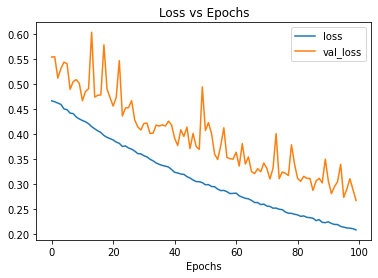

In [ ]:
model_fnn_metrics[['loss','val_loss']].plot()
plt.xlabel('Epochs')
plt.title('Loss vs Epochs')
plt.show()

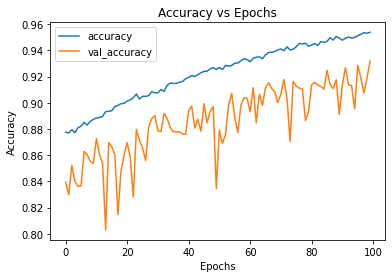

In [ ]:
model_fnn_metrics[['accuracy','val_accuracy']].plot()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()


### Find best Hyperparamters for **optimizer** and **lerning rate**

In [ ]:
'''def build_classifier(optimizer = 'adam', learning_rate=1e-1):
  classifier =  build_fc_model()

  if optimizer == 'SGD':
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  if optimizer == 'RMSprop':
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  if optimizer == 'Adagrad':
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
  if optimizer == 'Adadelta':
    optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
  if optimizer == 'Adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  if optimizer == 'Adamax':
    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
  if optimizer == 'Nadam':
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

  classifier.compile( optimizer = optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return classifier

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(optimizer=optimizer, learning_rate = learning_rate)

# create model
my_wrapper_model = KerasClassifier(build_fn=build_classifier, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
grid = GridSearchCV(estimator=my_wrapper_model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')

start_time = time.time()
grid_result = grid.fit(X_train, Y_train)
print(f'--- {(time.time() - start_time)/60:.3f} minutes ---')'''

"def build_classifier(optimizer = 'adam', learning_rate=1e-1):\n  classifier =  build_fc_model()\n\n  if optimizer == 'SGD':\n    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)\n  if optimizer == 'RMSprop':\n    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)\n  if optimizer == 'Adagrad':\n    optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)\n  if optimizer == 'Adadelta':\n    optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)\n  if optimizer == 'Adam':\n    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)\n  if optimizer == 'Adamax':\n    optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)\n  if optimizer == 'Nadam':\n    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)\n\n  classifier.compile( optimizer = optimizer,\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n  return classifier\n\noptimizer = ['SGD', 'RMSprop', 'Ad

In [ ]:
'''# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) with: %r" % (mean, stdev, param))
    '''

'# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\n#for mean, stdev, param in zip(means, stds, params):\n    #print("%f (%f) with: %r" % (mean, stdev, param))\n    '